## 06/04/2021 

The VAE detector was the best performing model, so a full implementation of the detection system using this model was built. This system would be an online detector which takes audio signal in real time using a microphone, loads the vae model from the previous notebooks, calculate the anomaly score using the vae model, then plot the anomaly over the top to of a spectorgram.


As before, first load in all the relevant libraries.

In [1]:
import torch 
import json 
import numpy as np 
from torch.utils.data import SubsetRandomSampler, DataLoader,TensorDataset
from torch.autograd import Variable 

from tqdm import tqdm 
import torch.nn.functional as F
from torch import nn


In [2]:
# soil mechanics - how fast do they grow? 


In [3]:
DATA_PATH = "./data/synthetic/train_data.json"
TEST_PATH = "./data/synthetic/test_data.json"

SAVED_MODEL_PATH_E = "./models/model_vaeE.pth"
SAVED_MODEL_PATH_D = "./models/model_vaeD.pth"
SAVED_MODEL_PATH_G = "./models/model_vaeG.pth"

In [4]:



def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device)for x in data]
    else:
        return data.to(device, non_blocking = True)
    

    
device = torch.device('cuda')



## 06/04/2021 

In order to use the trained model parameters, the model must be instantiated again with architecture which is exactly the same as the one specified by the model parameters. 

The same encoder, bottleneck and decoder network is defined and instantiated. 



In [5]:
latent_size = 9
# https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,stride = 2, padding=1 , kernel_size=3)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(32,64, stride = 2, padding =1, kernel_size=3)
        self.conv3 = nn.Conv2d(64,128,stride =2, padding =1, kernel_size = 3)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4096,latent_size)

    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)        
        out = self.relu(out)
        out = self.flatten(out)
        out1 = self.relu(self.linear(out))
        out2 = self.relu(self.linear(out))
        
        return out1, out2
    
def reparameterise(mu, log_var, training_mode):
    if training_mode:
        std = torch.exp(0.5*log_var)
        eps = Variable(std.data.new(std.size()).normal_())
        sample = mu + (eps*std)
        return sample 
    else:
        return mu 
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(latent_size,4096)
        self.relu = nn.LeakyReLU(0.2)

        self.deconv3 = nn.ConvTranspose2d(128,64,stride =2, kernel_size = 3, padding =1,output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64,32,stride =2, kernel_size = 3,padding =1,output_padding=1)
        self.deconv1 = nn.ConvTranspose2d(32,1,stride =2, kernel_size = 3,padding =1,output_padding=1)
        
    def forward(self, xb):
        out = self.fc(xb)
        out = self.relu(out)
        out = out.reshape(-1,128,16,2)
        out = self.deconv3(out)
        out = self.relu(out)
        out = self.deconv2(out)
        out = self.relu(out)
        out = self.deconv1(out)
        return out

E_module = Encoder()
G_module = Decoder()
D_module = Decoder()


latent_size = 9
# https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763

class Encoder(nn.Module):
    '''Encoder is a convolutional'''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,stride = 2, padding=1 , kernel_size=3)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(32,64, stride = 2, padding =1, kernel_size=3)
        self.conv3 = nn.Conv2d(64,128,stride =2, padding =1, kernel_size = 3)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4096,latent_size)

    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)        
        out = self.relu(out)
        out = self.flatten(out)
        out1 = self.relu(self.linear(out))
        out2 = self.relu(self.linear(out))
        
        return out1, out2
    
def reparameterise(mu, log_var, training_mode):
    if training_mode:
        std = torch.exp(0.5*log_var)
        eps = Variable(std.data.new(std.size()).normal_())
        sample = mu + (eps*std)
        return sample 
    else:
        return mu 
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(latent_size,4096)
        self.relu = nn.LeakyReLU(0.2)

        self.deconv3 = nn.ConvTranspose2d(128,64,stride =2, kernel_size = 3, padding =1,output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64,32,stride =2, kernel_size = 3,padding =1,output_padding=1)
        self.deconv1 = nn.ConvTranspose2d(32,1,stride =2, kernel_size = 3,padding =1,output_padding=1)
        
    def forward(self, xb):
        out = self.fc(xb)
        out = self.relu(out)
        out = out.reshape(-1,128,16,2)
        out = self.deconv3(out)
        out = self.relu(out)
        out = self.deconv2(out)
        out = self.relu(out)
        out = self.deconv1(out)
        return out

E_module = Encoder()
G_module = Decoder()
D_module = Decoder()
E_module.to(device)
G_module.to(device)
D_module.to(device)

E_module.load_state_dict(torch.load(SAVED_MODEL_PATH_E))
G_module.load_state_dict(torch.load(SAVED_MODEL_PATH_G))
D_module.load_state_dict(torch.load(SAVED_MODEL_PATH_D))

<All keys matched successfully>

In [8]:
'''
from torchsummary import summary 
print(summary(E_module, input_size = (1,128,16)))
print(summary(G_module, input_size = (1,9)))
print(summary(D_module, input_size = (1,9)))
'''



'\nfrom torchsummary import summary \nprint(summary(E_module, input_size = (1,128,16)))\nprint(summary(G_module, input_size = (1,9)))\nprint(summary(D_module, input_size = (1,9)))\n'

In [6]:
def loss_function(images, reconstructed, mu,logvar):
    mse = nn.MSELoss()
    mse_loss = mse(images,reconstructed)
    
    KLD = -0.5*torch.sum(1+logvar - mu.pow(2) - logvar.exp())
    KLD /= BATCH_SIZE * 128*16
    return KLD+mse_loss


In [7]:
def calc_anomaly_score(spectrogram):
    mu, logvar = E_module(spectrogram)
    reconstructed = G_module(latent)
    loss = loss_function(spectrogram, reconstructed, mu, logvar)
    return loss 


        

In [108]:
import librosa
import librosa.display
mse_per_image = nn.MSELoss(reduction='none')

def calc_frame_score(k):
    test_piece, sr = librosa.load(f"./vae_outputs/output{k}.wav")
    test_xt  = librosa.power_to_db(librosa.feature.melspectrogram(test_piece, n_mels = 128, fmax = 1024))
    test_xt = librosa.power_to_db(librosa.feature.melspectrogram(test_piece, n_mels =128, fmax= 1024))
    fig = plt.gcf()
    fig.set_size_inches(14,6)
    ax = plt.subplot()

    ax2 = ax.twinx()
    librosa.display.specshow(test_xt, fmax = 1024, y_axis = "mel", ax = ax, x_axis = 'time')

    score = []
    i =0 
    my_len = 16*512-1
    while i<len(test_piece)-my_len:
        piece = test_piece[i:i+my_len]
        xt  = librosa.power_to_db(librosa.feature.melspectrogram(piece, n_mels = 128, fmax = 1024))
        xt = torch.tensor(xt).float()
        xt = torch.unsqueeze(xt,0)
        xt = torch.unsqueeze(xt,0)
        xt = xt.to(device)
        mu, logvar = E_module(xt)
        z = reparameterise(mu, logvar, False)

        out = G_module(z)        
        loss = mse_per_image(out, xt)

        score.append(float(torch.sum(loss.detach().cpu())/(xt.shape[-1]*xt.shape[-2])))
        i+= 512
        
    x=[(i+8)*(512/sr) for i in range(len(score))]
    ax2.plot(x,score, alpha = 0.7)

    return score


## 06/04/2021 

The microphone from the computer is used in this case to simulate the real world implementation. it was impossible to go to the site of a real void so the audio source will be an ipad. This will likely result in a very different spectrogram as the ipad would not have a good frequency response in its low frequency regions. 

The function process was defined to open the channel for the microphone, then takes a chunk from the stream 

the calc frame score function will be written so that it can take a piece of audio, use the vae model to calculate its defect score, and return it. 

In [109]:
import librosa 
import pyaudio 
import wave 
import matplotlib.pyplot as plt

def process(k):
    CHUNK = 4096
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100

    RECORD_SECONDS = 10
    WAVE_OUTPUT_FILENAME = f"./vae_outputs/output{k}.wav"


    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)



    print(f"* recording {k}")

    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("* done recording")

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    
    score = calc_frame_score(k)
    return score 

0
* recording 0
* done recording


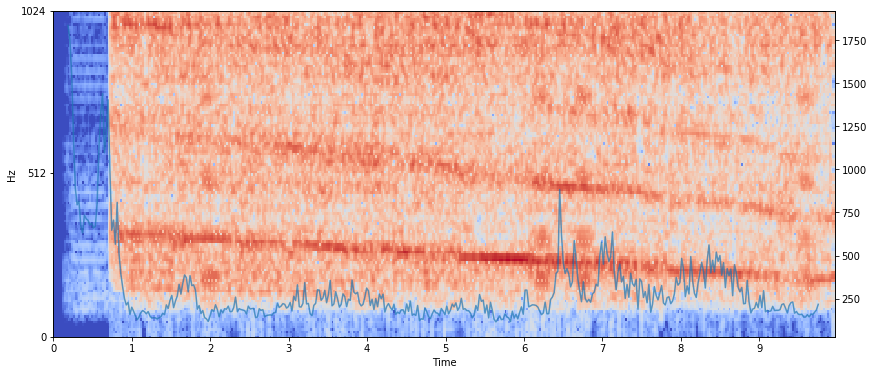

In [110]:
scores = []
import time
for i in range(1):
    print(i)
    scores.append(process(i))


## 06/04/2021  

The response from the model seems to be not very good, it was unable to produce high peaks at the locations of the voids. this is because the bottom region with frequencies below 150 hz is almost entirely blue, meaning there was a large antennuation in this region. 

This is expected because the ipad is not capable of producing very good bases. As a result, a high anomaly score was generated for almost the entire length of the signal. Note that the audio only started playing at time = 0.7 seconds, and before that because it was very quiet the detector was unable to respond. 

In [104]:
scores[0]

[1703.3251953125,
 1682.07177734375,
 1577.9310302734375,
 1145.0650634765625,
 756.2476196289062,
 743.1422119140625,
 690.817138671875,
 650.0946655273438,
 594.1262817382812,
 650.6325073242188,
 564.2896728515625,
 578.0111083984375,
 536.7735595703125,
 593.0413208007812,
 537.0380859375,
 525.1287841796875,
 564.0056762695312,
 569.3703002929688,
 643.5026245117188,
 618.591064453125,
 611.285888671875,
 676.285400390625,
 669.5603637695312,
 645.1910400390625,
 585.0921020507812,
 529.3740844726562,
 546.5030517578125,
 519.2127685546875,
 558.1796875,
 546.1273803710938,
 539.64990234375,
 494.3774108886719,
 651.47705078125,
 584.013427734375,
 548.3719482421875,
 595.3125610351562,
 648.8506469726562,
 598.8306274414062,
 585.4465942382812,
 644.715576171875,
 651.939208984375,
 706.3475341796875,
 682.6024169921875,
 721.4366455078125,
 727.3763427734375,
 686.8247680664062,
 661.534912109375,
 640.1591796875,
 628.8348388671875,
 701.3343505859375,
 657.89892578125,
 672.55